In [38]:
!pip install pmdarima
# setting logging to print only error messages from Sklearnex
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from datetime import datetime

from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error,mean_absolute_error
import tensorflow as tf
import os

from sklearn.metrics import mean_squared_error,mean_absolute_error
import math

import warnings
warnings.filterwarnings("ignore")

sns.set_theme(palette="Set2")


def get_mda(y, yhat):
    """Mean Directional Accuracy, as per:
    https://www.wikiwand.com/en/Mean_Directional_Accuracy
    """
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]


In [39]:
df=pd.read_csv("APPLE BP DATA.csv")

In [40]:
df.head()

,Date,Open,High,Low,Close,Volume,NASDAQ,Change
0,01-04-2014,19.205713,19.352501,19.170357,19.344643,200760000,3658.399902,NaN
1,02-04-2014,19.370714,19.410000,19.295000,19.376785,180420800,3665.989990,0.032142
2,03-04-2014,19.335358,19.375000,19.201429,19.242500,162344000,3637.580078,-0.134285
3,04-04-2014,19.278929,19.285713,18.949286,18.993570,275251200,3539.379883,-0.248930
4,07-04-2014,18.857857,18.960714,18.638929,18.695356,289850400,3507.750000,-0.298214


In [49]:
df = df.iloc[:-62, :]

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2205 non-null   object 
 1   Open    2205 non-null   float64
 2   High    2205 non-null   float64
 3   Low     2205 non-null   float64
 4   Close   2205 non-null   float64
 5   Volume  2205 non-null   int64  
 6   NASDAQ  2205 non-null   float64
 7   Change  2204 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 137.9+ KB


## Convert the "time" column to the datetime type

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2205 non-null   object 
 1   Open    2205 non-null   float64
 2   High    2205 non-null   float64
 3   Low     2205 non-null   float64
 4   Close   2205 non-null   float64
 5   Volume  2205 non-null   int64  
 6   NASDAQ  2205 non-null   float64
 7   Change  2204 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 137.9+ KB


In [43]:
df["Date"] = pd.to_datetime(df["Date"])

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2205 non-null   datetime64[ns]
 1   Open    2205 non-null   float64       
 2   High    2205 non-null   float64       
 3   Low     2205 non-null   float64       
 4   Close   2205 non-null   float64       
 5   Volume  2205 non-null   int64         
 6   NASDAQ  2205 non-null   float64       
 7   Change  2204 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 137.9 KB


In [45]:
df.set_index('Date',inplace=True)

In [46]:
df.head()

,Open,High,Low,Close,Volume,NASDAQ,Change
Date,,,,,,,
2014-01-04,19.205713,19.352501,19.170357,19.344643,200760000,3658.399902,NaN
2014-02-04,19.370714,19.410000,19.295000,19.376785,180420800,3665.989990,0.032142
2014-03-04,19.335358,19.375000,19.201429,19.242500,162344000,3637.580078,-0.134285
2014-04-04,19.278929,19.285713,18.949286,18.993570,275251200,3539.379883,-0.248930
2014-07-04,18.857857,18.960714,18.638929,18.695356,289850400,3507.750000,-0.298214


In [47]:
df.drop(['Open', 'High','Low','NASDAQ','Volume',"Change"], axis=1,inplace=True)


In [48]:
df

,Close
Date,
2014-01-04,19.344643
2014-02-04,19.376785
2014-03-04,19.242500
2014-04-04,18.993570
2014-07-04,18.695356
...,...
2022-12-23,131.860001
2022-12-27,130.029999
2022-12-28,126.040001


# Missing entries

In [12]:
min(df.index)

Timestamp('2014-01-04 00:00:00')

In [13]:
max(df.index)

Timestamp('2022-12-30 00:00:00')

In [14]:
all_datetimes = pd.date_range(min(df.index), max(df.index), freq="D")
all_datetimes

DatetimeIndex(['2014-01-04', '2014-01-05', '2014-01-06', '2014-01-07',
               '2014-01-08', '2014-01-09', '2014-01-10', '2014-01-11',
               '2014-01-12', '2014-01-13',
               ...
               '2022-12-21', '2022-12-22', '2022-12-23', '2022-12-24',
               '2022-12-25', '2022-12-26', '2022-12-27', '2022-12-28',
               '2022-12-29', '2022-12-30'],
              dtype='datetime64[ns]', length=3283, freq='D')

In [15]:
all_datetimes.shape

(3283,)

# Supplying missing values


## Insert missing datetimes

In [16]:
all_datetimes_df = pd.DataFrame(index=all_datetimes)
all_datetimes_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Freq: D
Empty DataFrame

In [17]:
df = pd.merge(all_datetimes_df, df, how="left", left_index=True, right_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3283 entries, 2014-01-04 to 2022-12-30
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2205 non-null   float64
dtypes: float64(1)
memory usage: 180.3 KB


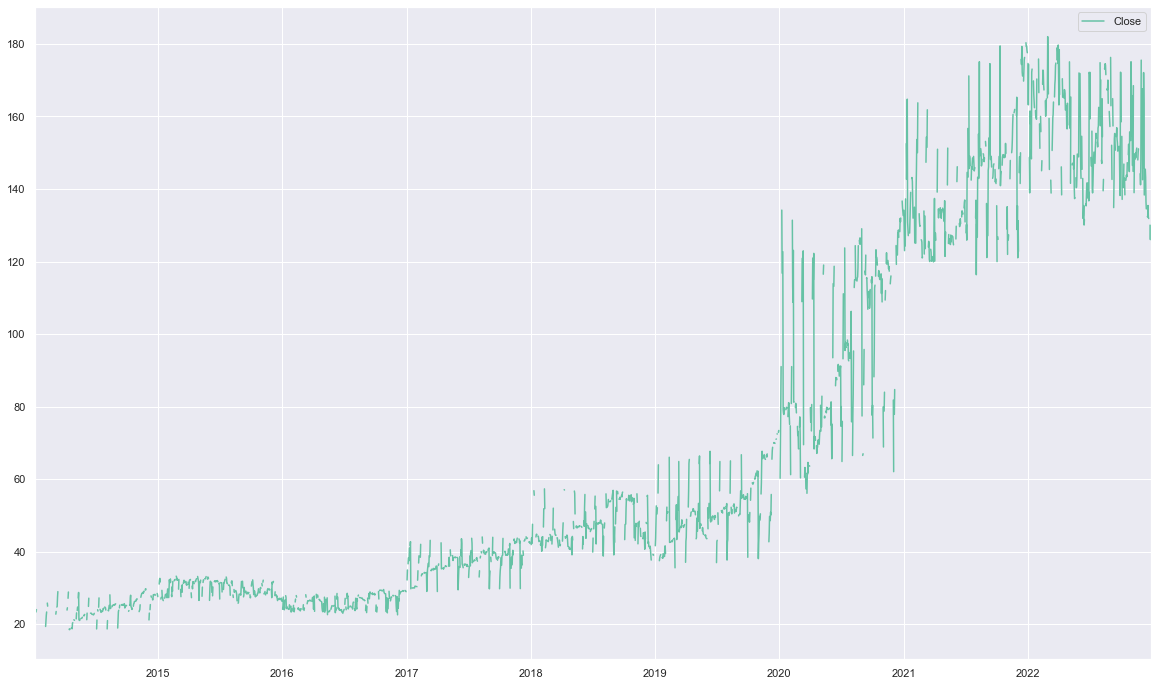

In [18]:
plot = df.head(3619).plot(figsize=(20, 12))

# forward fill

In [19]:
df["ffilled"] = df["Close"].ffill()
df.head(12)

,Close,ffilled
2014-01-04,19.344643,19.344643
2014-01-05,21.124287,21.124287
2014-01-06,NaN,21.124287
2014-01-07,23.379999,23.379999
2014-01-08,24.032499,24.032499
2014-01-09,NaN,24.032499
2014-01-10,24.795000,24.795000
2014-01-11,NaN,24.795000
2014-01-12,28.767500,28.767500
2014-01-13,NaN,28.767500


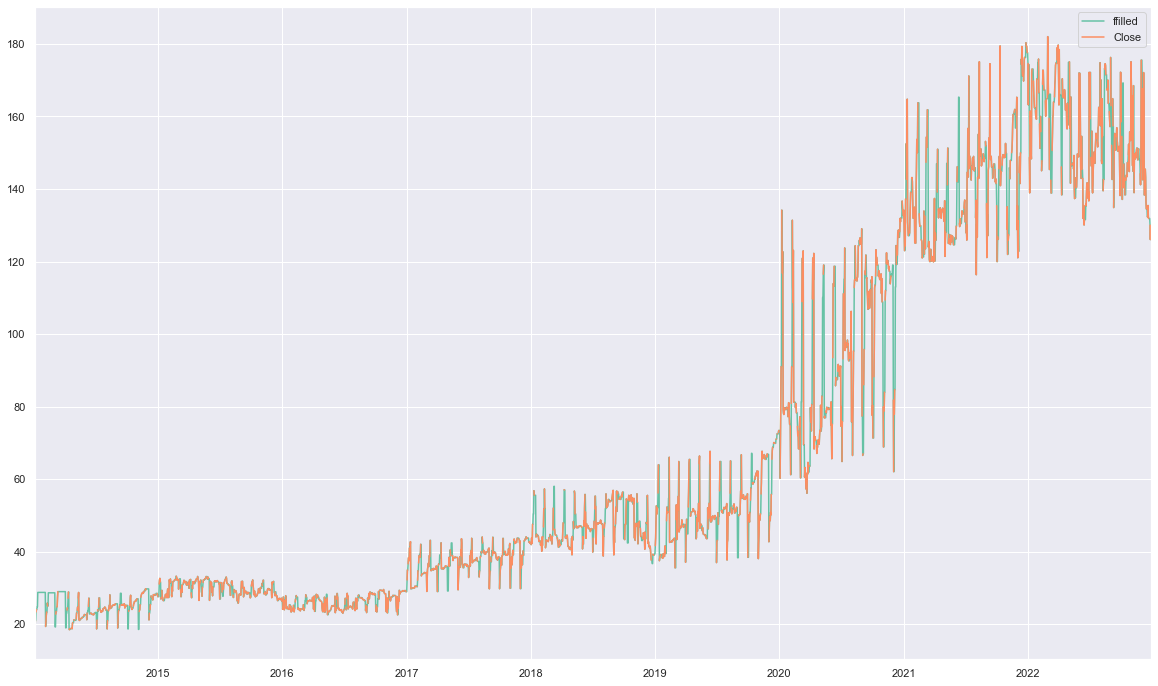

In [20]:
df = df[["ffilled", "Close"]]
plot = df.head(3619).plot(figsize=(20, 12))

In [21]:
df.ffilled

2014-01-04     19.344643
2014-01-05     21.124287
2014-01-06     21.124287
2014-01-07     23.379999
2014-01-08     24.032499
                 ...    
2022-12-26    131.860001
2022-12-27    130.029999
2022-12-28    126.040001
2022-12-29    129.610001
2022-12-30    129.929993
Freq: D, Name: ffilled, Length: 3283, dtype: float64

In [22]:
df.rename(columns={"ffilled": "close"}, inplace=True)
df

,close,Close
2014-01-04,19.344643,19.344643
2014-01-05,21.124287,21.124287
2014-01-06,21.124287,NaN
2014-01-07,23.379999,23.379999
2014-01-08,24.032499,24.032499
...,...,...
2022-12-26,131.860001,NaN
2022-12-27,130.029999,130.029999
2022-12-28,126.040001,126.040001
2022-12-29,129.610001,129.610001


In [23]:
df.drop(["Close"],axis=1,inplace=True)

In [24]:
df

,close
2014-01-04,19.344643
2014-01-05,21.124287
2014-01-06,21.124287
2014-01-07,23.379999
2014-01-08,24.032499
...,...
2022-12-26,131.860001
2022-12-27,130.029999
2022-12-28,126.040001
2022-12-29,129.610001


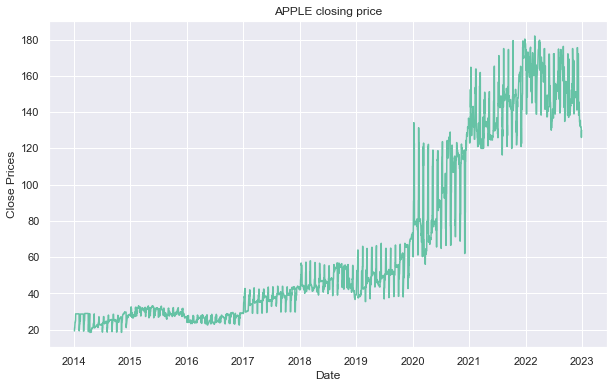

In [25]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['close'])
plt.title('APPLE closing price')
plt.show()

# checking stationarity of the data

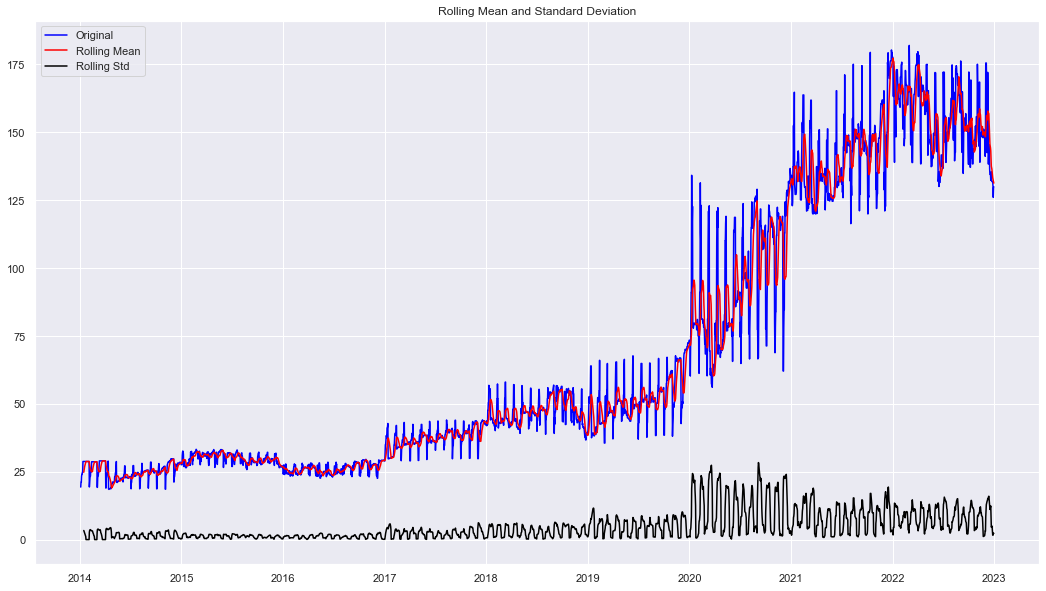

Results of dickey fuller test
Test Statistics                   0.752875
p-value                           0.990836
No. of lags used                 29.000000
Number of observations used    3253.000000
critical value (1%)              -3.432362
critical value (5%)              -2.862429
critical value (10%)             -2.567243
dtype: float64


In [26]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    plt.figure(figsize=(18, 10))

    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df.close)

## Differencing

In [27]:
diff_df=df.diff()
diff_df

,close
2014-01-04,NaN
2014-01-05,1.779644
2014-01-06,0.000000
2014-01-07,2.255712
2014-01-08,0.652500
...,...
2022-12-26,0.000000
2022-12-27,-1.830002
2022-12-28,-3.989998
2022-12-29,3.570000


# TRAIN TEST SPLIT

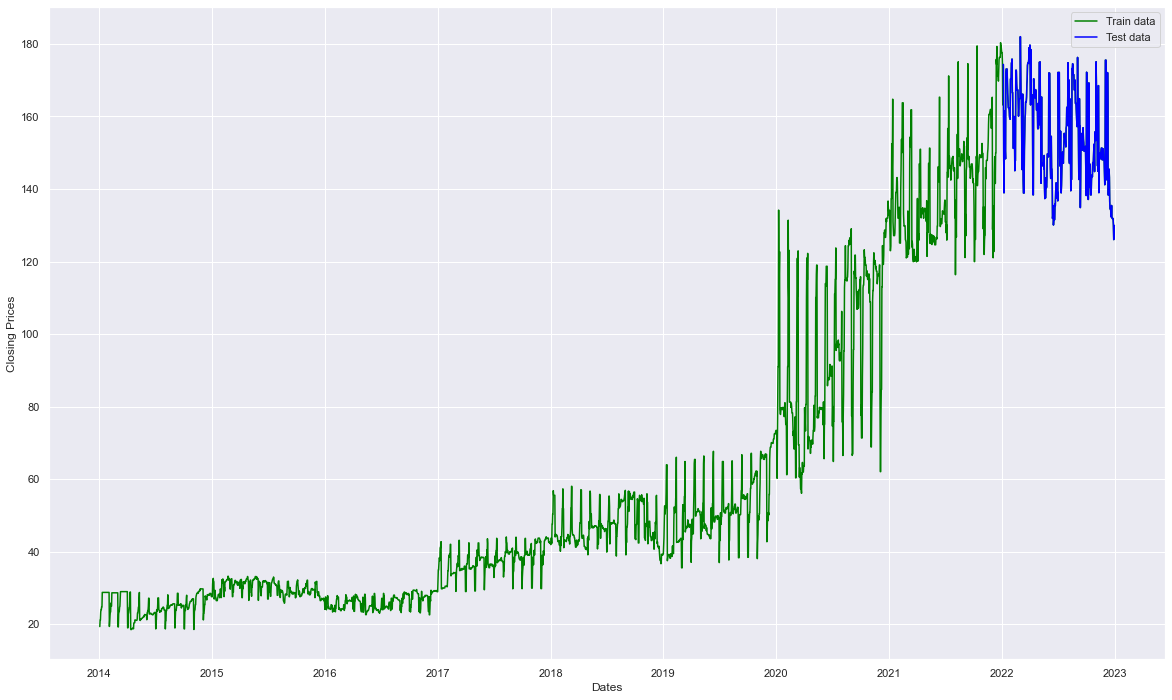

In [28]:
#split data into train and training set
#train_data, test_data = df[3:int(len(df)*0.9)], df[int(len(df)*0.9):]
train_data = df.loc[df.index < '01-04-2022']
test_data = df.loc[df.index >= '01-04-2022']
plt.figure(figsize=(20,12))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [29]:
train_data.shape

(2922, 1)

In [30]:
test_data.shape

(361, 1)

# AUTO ARIMA

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17989.890, Time=0.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17951.236, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17952.700, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17988.146, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17953.108, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17953.174, Time=0.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17954.706, Time=1.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=17949.565, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=17951.432, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=17951.500, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=17951.035, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=17953.024, Time=0.28 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 3.397 seconds
                               SARIMAX Results                              

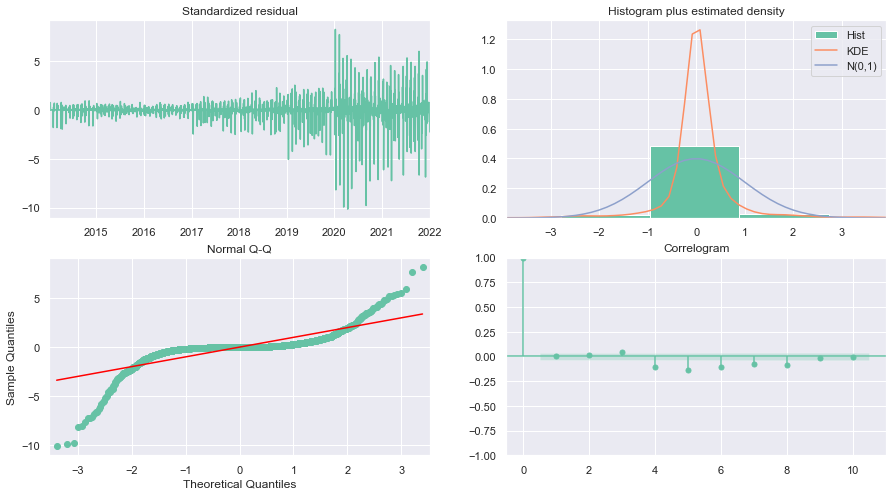

In [31]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [32]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(1,1,0))

fitted=model.fit()

model_summary = fitted.summary()
print(model_summary)

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 2922
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -8972.783
Date:                Sun, 24 Sep 2023   AIC                          17949.565
Time:                        22:05:08   BIC                          17961.525
Sample:                    01-04-2014   HQIC                         17953.873
                         - 01-03-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1175      0.011    -11.179      0.000      -0.138      -0.097
sigma2        27.2761      0.193    141.054      0.000      26.897      27.655
Ljung-Box (L1) (Q):                   0.00   Jarque-

# Forecasting on test dataset

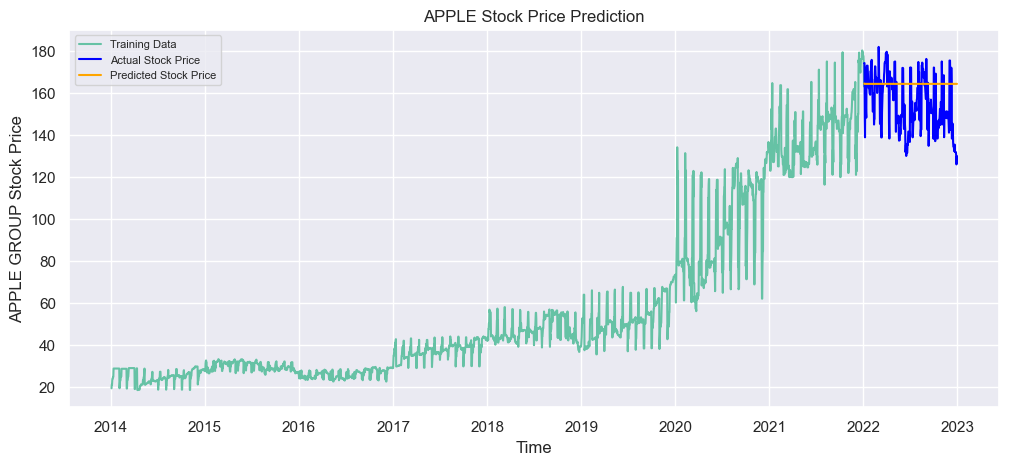

In [33]:
# Forecast
forecast_steps = 361  # Adjust this to your desired number of forecasted time steps
forecast_values = fitted.forecast(steps=forecast_steps)  # Forecast values

# Make as pandas series
fc_series = pd.Series(forecast_values, index=test_data.index)  # Use the appropriate index

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.title('APPLE Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('APPLE GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

##  Evaluating Forecast results

In [34]:
# report performance
mse = mean_squared_error(test_data, forecast_values)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, forecast_values)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, forecast_values))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(forecast_values - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 256.58383755425814
MAE: 13.149932097443731
RMSE: 16.018234533002012
MAPE: 2022-01-04 00:00:00   NaN
2022-01-05 00:00:00   NaN
2022-01-06 00:00:00   NaN
2022-01-07 00:00:00   NaN
2022-01-08 00:00:00   NaN
                       ..
2022-12-27 00:00:00   NaN
2022-12-28 00:00:00   NaN
2022-12-29 00:00:00   NaN
2022-12-30 00:00:00   NaN
close                 NaN
Length: 362, dtype: float64


In [35]:
def mean_directional_accuracy(actual, forecasted):
    # Calculate the directional changes in actual and forecasted values
    actual_changes = np.sign(np.diff(actual))
    forecasted_changes = np.sign(np.diff(forecasted))
    
    # Calculate MDA by comparing directional changes
    mda = np.mean(actual_changes == forecasted_changes)
    return mda

# Assuming you have test_data and forecast_values
mda = mean_directional_accuracy(test_data, forecast_values)
print('Mean Directional Accuracy (MDA): {:.2%}'.format(mda))

Mean Directional Accuracy (MDA): 0.00%


In [36]:
forecast_values.tail()

2022-12-26    164.399566
2022-12-27    164.399566
2022-12-28    164.399566
2022-12-29    164.399566
2022-12-30    164.399566
Freq: D, Name: predicted_mean, dtype: float64

In [37]:
forecast_values.head()

2022-01-04    164.540497
2022-01-05    164.383009
2022-01-06    164.401511
2022-01-07    164.399337
2022-01-08    164.399593
Freq: D, Name: predicted_mean, dtype: float64